# Project Title: Inflation in switzerland in the past 25 years

## Libraries and settings

In [12]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats

# -------------------------------
# OOP Class for Inflation Analysis
# -------------------------------

class InflationData:
    def __init__(self, api_key, series_id='FPCPITOTLZGCHE'):
        self.api_key = api_key
        self.series_id = series_id
        self.df = None
        self.filtered_df = None
        self.inflation_dict = None

    def fetch_data_from_fred(self):
        """Fetch inflation data from FRED API."""
        url = f'https://api.stlouisfed.org/fred/series/observations?series_id={self.series_id}&api_key={self.api_key}&file_type=json'
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception(f"Error fetching data: Status code {response.status_code}")
        data_json = response.json()
        observations = data_json.get('observations', [])
        self.df = pd.DataFrame(observations)
        print("Data successfully fetched and loaded into DataFrame.")

    def preprocess_data(self):
        """Convert date and value columns to correct data types and filter data."""
        if self.df is None:
            raise Exception("Data not loaded. Call fetch_data_from_fred() first.")
        
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df['value'] = pd.to_numeric(self.df['value'], errors='coerce')
        self.filtered_df = self.df[self.df['date'].dt.year >= 2000].copy()

        # Create a dictionary from the filtered data
        self.inflation_dict = {int(row['date'].year): row['value'] for _, row in self.filtered_df.iterrows()}
        print("Data preprocessing complete.")

    def plot_inflation_trend(self):
        """Plot inflation trend as a line chart."""
        if self.filtered_df is None:
            raise Exception("Data not preprocessed. Call preprocess_data() first.")
        
        plt.figure(figsize=(10,6))
        plt.plot(self.filtered_df['date'], self.filtered_df['value'], marker='o')
        plt.title('Swiss Inflation Rate (2000–2024)', fontsize=14)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Inflation (%)', fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_inflation_distribution(self):
        """Plot inflation distribution as a histogram."""
        if self.filtered_df is None:
            raise Exception("Data not preprocessed. Call preprocess_data() first.")
        
        plt.figure(figsize=(8,6))
        plt.hist(self.filtered_df['value'].dropna(), bins=10, edgecolor='black')
        plt.title('Distribution of Swiss Inflation Rates (2000–2024)', fontsize=14)
        plt.xlabel('Inflation (%)', fontsize=12)
        plt.ylabel('Number of Years', fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def perform_statistical_analysis(self):
        """Conduct a t-test comparing two periods: 2000–2010 and 2011–2024."""
        if self.filtered_df is None:
            raise Exception("Data not preprocessed. Call preprocess_data() first.")
        
        group_1 = self.filtered_df[(self.filtered_df['date'].dt.year >= 2000) & (self.filtered_df['date'].dt.year <= 2010)]['value']
        group_2 = self.filtered_df[(self.filtered_df['date'].dt.year >= 2011) & (self.filtered_df['date'].dt.year <= 2024)]['value']
        
        t_stat, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)

        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value:.4f}")

        if p_value < 0.05:
            print("There is a significant difference between the two periods (p < 0.05).")
        else:
            print("There is no significant difference between the two periods (p ≥ 0.05).")

    def save_to_sqlite(self, db_name='inflation_ch.db'):
        """Save the filtered inflation data into an SQLite database."""
        if self.inflation_dict is None:
            raise Exception("Inflation dictionary not created. Call preprocess_data() first.")
        
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()
        
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS inflation_data (
            year INTEGER PRIMARY KEY,
            inflation_rate REAL
        )
        ''')

        for year, rate in self.inflation_dict.items():
            cursor.execute('INSERT OR REPLACE INTO inflation_data (year, inflation_rate) VALUES (?, ?)', (year, rate))

        conn.commit()
        conn.close()
        print(f"Data successfully saved to {db_name}.")

# -------------------------------
# Main Function
# -------------------------------

def main():
    # Insert your FRED API key here
    api_key = '92d4205f1f82cfc1c2e3ef308d856803'

    # Create InflationData object
    inflation_data = InflationData(api_key)

    # Run the full workflow
    inflation_data.fetch_data_from_fred()
    inflation_data.preprocess_data()
    inflation_data.plot_inflation_trend()
    inflation_data.plot_inflation_distribution()
    inflation_data.perform_statistical_analysis()
    inflation_data.save_to_sqlite()

# Note: Call the main() function explicitly in a separate cell if needed.


Data successfully fetched and loaded into DataFrame.
Data preprocessing complete.


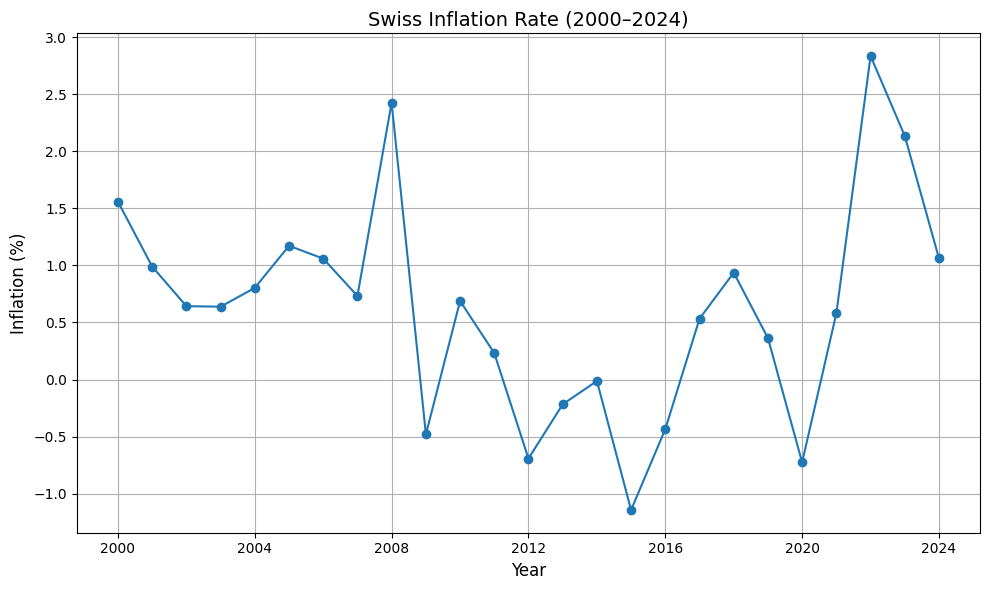

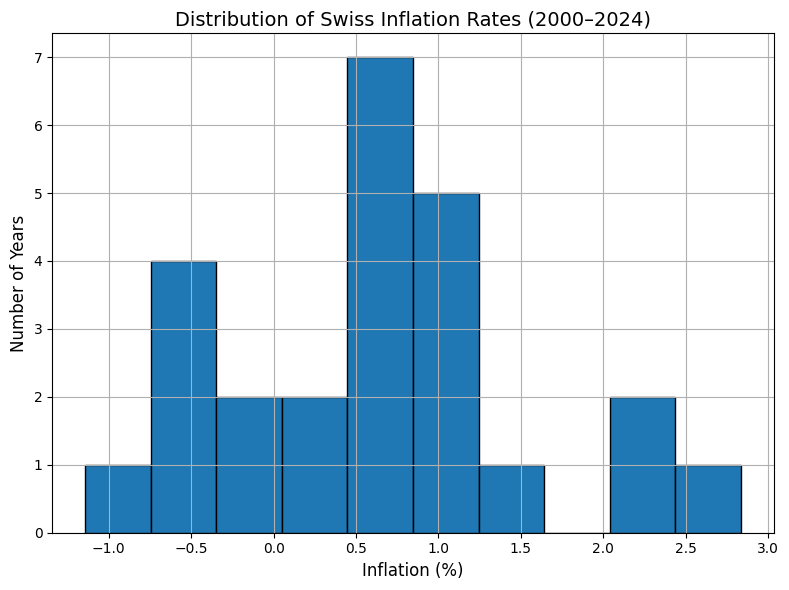

T-statistic: 1.4859
P-value: 0.1514
There is no significant difference between the two periods (p ≥ 0.05).
Data successfully saved to inflation_ch.db.


In [13]:
main()